In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import words, stopwords

from wordcloud import WordCloud

import pickle

In [71]:
import gensim
from gensim import models
from gensim.models import TfidfModel
from gensim.models import CoherenceModel, LdaMulticore
from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.gensim_models 

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [9]:
DATA_PATH = 'data/2_preprocessed_data/'

In [10]:
bad_reviews = pd.read_csv(DATA_PATH + 'bad_reviews',
                          dtype={
                                 "review_id": str,
                                 "user_id": str,
                                 "business_id": str,
                                 "stars": 'uint8',
                                 "useful": 'int16',
                                 "funny": 'int16',
                                 "cool": 'int16',
                                 "text": str,
                                } 
                         )

In [12]:
good_reviews = pd.read_csv(DATA_PATH + 'good_reviews',
                          dtype={
                                 "review_id": str,
                                 "user_id": str,
                                 "business_id": str,
                                 "stars": 'uint8',
                                 "useful": 'int16',
                                 "funny": 'int16',
                                 "cool": 'int16',
                                 "text": str,
                                } 
                         )

In [13]:
sample_reviews = pd.read_csv(DATA_PATH + 'sample_reviews',
                          dtype={
                                 "review_id": str,
                                 "user_id": str,
                                 "business_id": str,
                                 "stars": 'uint8',
                                 "useful": 'int16',
                                 "funny": 'int16',
                                 "cool": 'int16',
                                 "text": str,
                                } 
                         )

## Corpus

In [14]:
corpus_bad    = ". ".join(list(bad_reviews.text))
corpus_good   = ". ".join(list(good_reviews.text))
corpus_sample = ". ".join(list(sample_reviews.text))

## Cleaning function

In [15]:
def process_text(doc,
                 stop_words,
                 rejoin=False,
                 lem_or_stem="stem",
                 rare_words=None,
                 min_len_word=3,
                 force_is_alpha=True,
                 context=None,
                 english_words=None):
    """Process a text with selection of english words
    positionnal args :
    -------------------
    doc: str: the document to process
    
    optional args :
    ----------------
    rejoin: bool: if False return a list of words, else return the string of joined element of the list
    lem_or_stem : choice between lemmatize and stemmatize
    rare_words: list : list of rare words to exclude
    force_is_alpha: int: if 1 exclude all tokens with a numeric character
    english_words: list: list of english words accepted
    
    return:
    --------
    List of tokens if rejoin=False, the joined list if True.
    """
    if not rare_words:
        rare_words=[]
    
    doc = doc.lower().strip()
    
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)
    
    cleaned_tokens_list = [word for word in raw_tokens_list if word not in stop_words]
    
    non_rare_tokens = [word for word in cleaned_tokens_list if word not in rare_words]
    
    large_words = [word for word in non_rare_tokens if len(word) >= min_len_word]
    
    if force_is_alpha:
        alpha_tokens = [word for word in large_words if word.isalpha()]
    else:
        alpha_tokens = large_words
        
    if lem_or_stem == "lem":
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else:
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]
        
    if context:
        new_text = [word for word in trans_text if word not in context]
    else:
        new_text = trans_text
        
    if english_words:
        english_text = [i for i in new_text if i in english_words]
    else:
        english_text = new_text
        
    if rejoin:
        return " ".join(english_text)
    else:
        return english_text

In [16]:
def display_tokens_info(tokens):
    """Display info about corpus"""
    print(f"Nb tokens : {len(tokens)}")
    print(f"Nb tokens uniques : {len(set(tokens))}")
    print(tokens[:30])

## Process corpus

In [17]:
stop_words = set(stopwords.words('english'))

In [18]:
corpus_bad_1 = process_text(corpus_bad, stop_words=stop_words,)

display_tokens_info(corpus_bad_1)

Nb tokens : 368787
Nb tokens uniques : 11543
['late', 'post', 'loufest', 'group', 'decid', 'nourish', 'delici', 'greasi', 'food', 'bed', 'courtesi', 'diner', 'next', 'door', 'pack', 'opt', 'steak', 'shake', 'amaz', 'cheap', 'serious', 'everyth', 'like', 'littl', 'nicer', 'mcdonald', 'imo', 'got', 'frisco', 'melt']


In [19]:
corpus_good_1 = process_text(corpus_good, stop_words=stop_words,)

display_tokens_info(corpus_good_1)

Nb tokens : 299513
Nb tokens uniques : 11642
['mickey', 'sweetheart', 'fun', 'spirit', 'sandwich', 'best', 'huge', 'sandwhich', 'critic', 'got', 'italian', 'wait', 'tri', 'london', 'broil', 'next', 'best', 'vegan', 'place', 'area', 'alway', 'come', 'new', 'stuff', 'keep', 'around', 'classic', 'know', 'anyth', 'tri']


In [20]:
corpus_sample_1 = process_text(corpus_sample, stop_words=stop_words,)

display_tokens_info(corpus_sample_1)

Nb tokens : 1072372
Nb tokens uniques : 21825
['late', 'post', 'loufest', 'group', 'decid', 'nourish', 'delici', 'greasi', 'food', 'bed', 'courtesi', 'diner', 'next', 'door', 'pack', 'opt', 'steak', 'shake', 'amaz', 'cheap', 'serious', 'everyth', 'like', 'littl', 'nicer', 'mcdonald', 'imo', 'got', 'frisco', 'melt']


## Rare words

In [21]:
tmp = pd.Series(corpus_sample_1).value_counts()

In [22]:
tmp

food           16511
order          12392
place          11935
good           11897
time            8899
               ...  
perfecta           1
combinación        1
panni              1
willamett          1
flint              1
Length: 21825, dtype: int64

In [23]:
unique_words = tmp[tmp==1]

In [24]:
len(unique_words)

9215

In [25]:
unique_words = list(unique_words.index)

In [26]:
less_5_words = list(tmp[tmp<5].index)

In [27]:
len(less_5_words)

14494

In [28]:
less_10_words = list(tmp[tmp<10].index)

In [29]:
len(less_10_words)

16789

In [30]:
corpus_bad_2 = process_text(corpus_bad,
                            stop_words=stop_words,
                            rare_words=less_5_words)

In [31]:
corpus_good_2 = process_text(corpus_good,
                             stop_words=stop_words,
                             rare_words=less_5_words)

In [32]:
corpus_sample_2 = process_text(corpus_sample,
                               stop_words=stop_words,
                               rare_words=less_5_words)

In [33]:
display_tokens_info(corpus_bad_2)

Nb tokens : 362250
Nb tokens uniques : 8902
['late', 'post', 'group', 'decid', 'nourish', 'delici', 'greasi', 'food', 'bed', 'courtesi', 'diner', 'next', 'door', 'pack', 'opt', 'steak', 'shake', 'amaz', 'cheap', 'serious', 'everyth', 'like', 'littl', 'nicer', 'mcdonald', 'imo', 'got', 'frisco', 'melt', 'cheap']


In [34]:
display_tokens_info(corpus_good_2)

Nb tokens : 289429
Nb tokens uniques : 8485
['mickey', 'sweetheart', 'fun', 'spirit', 'sandwich', 'best', 'huge', 'sandwhich', 'critic', 'got', 'italian', 'wait', 'tri', 'london', 'broil', 'next', 'best', 'vegan', 'place', 'area', 'alway', 'come', 'new', 'stuff', 'keep', 'around', 'classic', 'know', 'anyth', 'tri']


In [35]:
display_tokens_info(corpus_sample_2)

Nb tokens : 1043943
Nb tokens uniques : 13735
['late', 'post', 'group', 'decid', 'nourish', 'delici', 'greasi', 'food', 'bed', 'courtesi', 'diner', 'next', 'door', 'pack', 'opt', 'steak', 'shake', 'amaz', 'cheap', 'serious', 'everyth', 'like', 'littl', 'nicer', 'mcdonald', 'imo', 'got', 'frisco', 'melt', 'cheap']


**Save**

Les traitements étant longs, on sauvegarde les corpus.

In [36]:
with open("results/corpus_bad", "wb") as fp:
    pickle.dump(corpus_bad_2, fp)
    
with open("results/corpus_good", "wb") as fp:
    pickle.dump(corpus_good_2, fp)
    
with open("results/corpus_sample", "wb") as fp:
    pickle.dump(corpus_sample_2, fp)

## First WordCloud

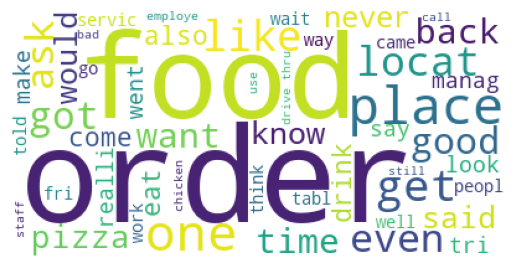

In [37]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_bad_2))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

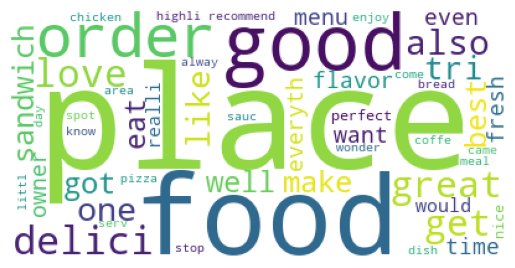

In [38]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_good_2))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

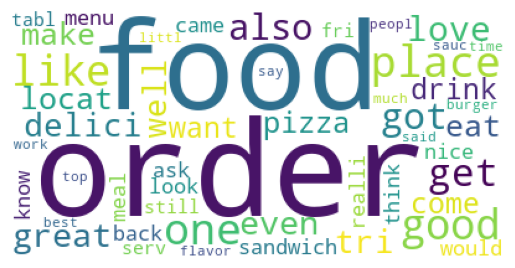

In [39]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_sample_2))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

On voit que beaucoup de mots sont communs aux différents nuages de mots : order, food, one, ...  
Construisons des mots de contexte pour que ces mots soient filtrés.

### Context

In [40]:
pd.Series(corpus_bad_2).value_counts().head(20)

order      6710
food       6123
time       4049
get        3639
place      3416
one        3090
like       3027
servic     2816
good       2663
wait       2529
back       2202
would      2100
minut      2043
locat      1937
ask        1883
got        1871
even       1846
pizza      1779
chicken    1691
want       1486
dtype: int64

In [41]:
pd.Series(corpus_good_2).value_counts().head(20)

food        4898
place       4031
great       3481
good        2854
tri         2513
delici      2494
love        2188
order       2093
best        2047
time        1982
back        1924
like        1779
also        1654
get         1652
one         1626
fresh       1604
friendli    1596
servic      1565
sandwich    1472
definit     1393
dtype: int64

In [42]:
n = 20
doublons = [i for i in pd.Series(corpus_bad_2).value_counts().head(n).index
            if i in pd.Series(corpus_good_2).value_counts().head(n).index]
doublons

['order',
 'food',
 'time',
 'get',
 'place',
 'one',
 'like',
 'servic',
 'good',
 'back']

In [43]:
pd.Series(corpus_sample_2).value_counts().head(20)

food       16511
order      12392
place      11935
good       11897
time        8899
great       8363
like        7952
get         7792
one         6961
servic      6950
tri         6191
back        6170
would       5415
realli      5048
wait        4736
also        4701
love        4691
got         4591
chicken     4476
delici      4402
dtype: int64

In [44]:
context = doublons

In [45]:
corpus_bad_3 = process_text(corpus_bad,
                            stop_words=stop_words,
                            rare_words=less_5_words,
                            context=context)

In [46]:
corpus_good_3 = process_text(corpus_good,
                             stop_words=stop_words,
                             rare_words=less_5_words,
                             context=context)

In [47]:
corpus_sample_3 = process_text(corpus_sample,
                               stop_words=stop_words,
                               rare_words=less_5_words,
                               context=context)

In [48]:
with open("results/corpus_bad_context", "wb") as fp:
    pickle.dump(corpus_bad_3, fp)
    
with open("results/corpus_good_context", "wb") as fp:
    pickle.dump(corpus_good_3, fp)
    
with open("results/corpus_sample_context", "wb") as fp:
    pickle.dump(corpus_sample_3, fp)

In [49]:
display_tokens_info(corpus_bad_2)

Nb tokens : 362250
Nb tokens uniques : 8902
['late', 'post', 'group', 'decid', 'nourish', 'delici', 'greasi', 'food', 'bed', 'courtesi', 'diner', 'next', 'door', 'pack', 'opt', 'steak', 'shake', 'amaz', 'cheap', 'serious', 'everyth', 'like', 'littl', 'nicer', 'mcdonald', 'imo', 'got', 'frisco', 'melt', 'cheap']


In [50]:
display_tokens_info(corpus_good_2)

Nb tokens : 289429
Nb tokens uniques : 8485
['mickey', 'sweetheart', 'fun', 'spirit', 'sandwich', 'best', 'huge', 'sandwhich', 'critic', 'got', 'italian', 'wait', 'tri', 'london', 'broil', 'next', 'best', 'vegan', 'place', 'area', 'alway', 'come', 'new', 'stuff', 'keep', 'around', 'classic', 'know', 'anyth', 'tri']


In [51]:
display_tokens_info(corpus_sample_2)

Nb tokens : 1043943
Nb tokens uniques : 13735
['late', 'post', 'group', 'decid', 'nourish', 'delici', 'greasi', 'food', 'bed', 'courtesi', 'diner', 'next', 'door', 'pack', 'opt', 'steak', 'shake', 'amaz', 'cheap', 'serious', 'everyth', 'like', 'littl', 'nicer', 'mcdonald', 'imo', 'got', 'frisco', 'melt', 'cheap']


## Second WordCloud

In [54]:
with open("results/corpus_bad", "rb") as fp:
    corpus_bad_3 = pickle.load(fp)

In [55]:
with open("results/corpus_good", "rb") as fp:
    corpus_good_3 = pickle.load(fp)

In [56]:
with open("results/corpus_sample", "rb") as fp:
    corpus_sample_3 = pickle.load(fp)

In [57]:
with open("results/filtered_words", "rb") as fp:
    filtered_words = pickle.load(fp)

In [58]:
import warnings
warnings.filterwarnings('ignore')

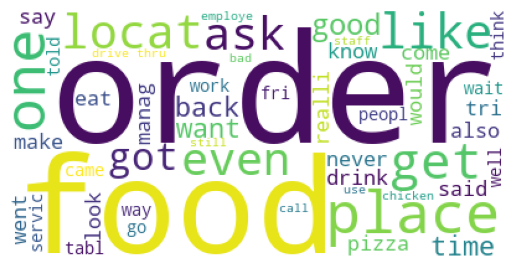

In [59]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_bad_3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

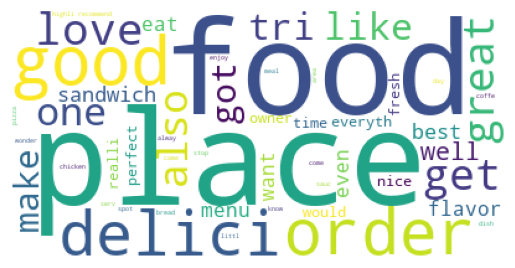

In [60]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_good_3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

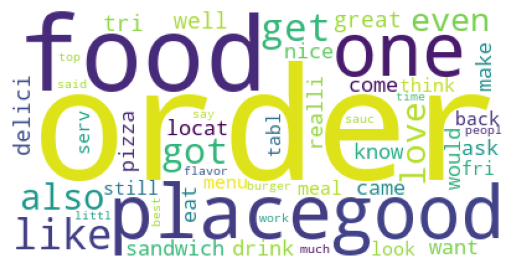

In [61]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_sample_3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# 2. Sujet d'insatisfaction avec LDA

In [62]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [63]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [66]:
bad_reviews = pd.read_csv(DATA_PATH + 'bad_reviews',
                          dtype={
                                 "review_id": str,
                                 "user_id": str,
                                 "business_id": str,
                                 "stars": 'uint8',
                                 "useful": 'int16',
                                 "funny": 'int16',
                                 "cool": 'int16',
                                 "text": str,
                                } 
                         )

In [67]:
filtered_words.append('would')

In [68]:
bad_reviews_corpus = [process_text(review, stop_words=filtered_words) for review in bad_reviews.text]

In [72]:
pyLDAvis.enable_notebook()

## 2.1. Choix du nombre de topics

In [73]:
with open("results/coherence", "rb") as fp:
    coherence_df = pickle.load(fp)

In [74]:
bigram = gensim.models.Phrases(bad_reviews_corpus, min_count=2, threshold=60) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[bad_reviews_corpus],threshold=60)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(all_doc):
    return [bigram_mod[doc] for doc in all_doc]

def make_trigrams(all_doc):
    return [trigram_mod[doc] for doc in all_doc]

In [75]:
data_clean_bigram = make_bigrams(bad_reviews_corpus)
data_clean_trigram = make_trigrams(bad_reviews_corpus)

In [76]:
id2word = Dictionary(data_clean_trigram)
texts = data_clean_trigram
corpus = [id2word.doc2bow(text) for text in texts]

In [77]:
model = TfidfModel(corpus)
corpus_tfidf = model[corpus]

In [78]:
# %%time

# coherences = dict()

# for k in range(3, 20):
#     print('Number of Topics: ' + str(k))
#     ldamodel = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, passes=40, iterations=20, chunksize=10000, eval_every=None, workers=30)
#     cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts, dictionary=id2word, coherence='c_v')
    
    
#     print(f"Coherence : {cm.get_coherence()}")
#     print("Coherence max :", coherence_max )
    
    
#     if cm.get_coherence() > coherence_max:
#         coherence_max = cm.get_coherence()
#         print("Model save \n")
#         ldamodel.save('results/lda.model')
#     coherences[k] = [cm.get_coherence()]

In [79]:
# for i in range(10):
#     print(f"\n Loop {i} \n")
#     coherences = dict()

#     for k in range(3, 20):
#         print('Number of Topics: ' + str(k))
#         ldamodel = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, passes=40, iterations=20, chunksize=10000, eval_every=None, workers=30)
#         cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts, dictionary=id2word, coherence='c_v')


#         print(f"Coherence : {cm.get_coherence()}")
#         print("Coherence max :", coherence_max )


#         if cm.get_coherence() > coherence_max:
#             coherence_max = cm.get_coherence()
#             print("Model save \n")
#             ldamodel.save('results/lda.model')
#         coherences[k] = [cm.get_coherence()]
        
#     coherence_df = pd.concat([coherence_df, pd.DataFrame(coherences)], ignore_index=True)

In [80]:
with open("results/coherence", "wb") as fp:
    pickle.dump(coherence_df, fp)

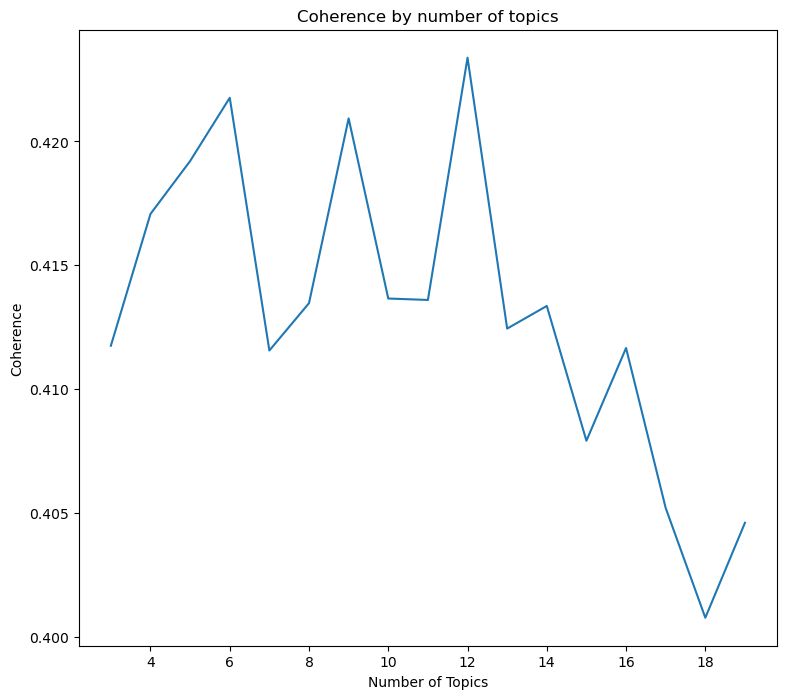

In [81]:
plt.figure(figsize=(9,8))
plt.plot(coherence_df.mean(axis=0))
plt.title('Coherence by number of topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.show()

## 2.2. Modélisation

In [82]:
with open("results/lda_texts", "wb") as fp:
    pickle.dump(texts, fp)

In [83]:
with open("results/lda_id2word", "wb") as fp:
    pickle.dump(id2word, fp)

In [84]:
with open("results/lda_corpus", "wb") as fp:
    pickle.dump(corpus, fp)

## Best model : 5 topics

In [ ]:
lda_best_model =  models.LdaModel.load('results/lda.model')
lda_best_model.num_topics

In [ ]:
cm = CoherenceModel(model=lda_best_model, texts=texts, dictionary=id2word, coherence='c_v')
cm.get_coherence()

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models .prepare(lda_best_model, corpus, id2word)

1. Delay
2. Bad order, Taste
3. Staff pb
4. Service
5. Pizza commands

## Performant model with 9 topics

In [ ]:
lda_model_9 =  models.LdaModel.load('results/9_topics/lda.model')
lda_model_9.num_topics

In [ ]:
cm = CoherenceModel(model=lda_model_9, texts=texts, dictionary=id2word, coherence='c_v')
cm.get_coherence()

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models .prepare(lda_model_9, corpus, id2word)
p

1. Command error
2. Service
3. Pizza commands
4. Delay
5. Fast food
6. Price vs quality
7. Command error
8. Polite
9. Area handling